# Efficiently iterating over rows in a Pandas DataFrame



Importamos un conjunto de datos en Pandas

In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/mlabonne/How-to-Data-Science/main/data/nslkdd_test.txt')
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,other
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


Este conjunto de datos tiene 22544 filas y 43 columnas con una combinación de valores categóricos y numéricos. Cada fila describe una conexión entre dos computadoras.

Digamos que queremos crear una nueva característica: el número total de bytes en la conexión. Solo tenemos que resumir dos características existentes: src_bytes y dst_bytes. Veamos diferentes métodos para calcular esta nueva característica.

## ❌ 1. Iterrows

 .iterrows() itera "sobre las filas de un Pandas DataFrame como pares (índice, Serie)". Convierte cada fila en un objeto Serie.

In [13]:
%%timeit -n 10
# Iterrows
total = []
for index, row in df.iterrows():
    total.append(row['src_bytes'] + row['dst_bytes'])

422 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Es el peor método posible para iterar sobre las filas.

## ❌ 2. For loop with .loc or .iloc (3× faster)

Los DataFrames no están diseñados para este propósito. Al igual que con el método anterior, las filas se convierten en objetos de la serie Pandas, lo que degrada el rendimiento.

In [3]:
%%timeit -n 10
# For loop with .loc
total = []
for index in range(len(df)):
    total.append(df['src_bytes'].loc[index] + df['dst_bytes'].loc[index])

322 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit -n 10
# For loop with .iloc
total = []
for index in range(len(df)):
    total.append(df['src_bytes'].iloc[index] + df['dst_bytes'].iloc[index])

208 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


.iloc es más rápido que .loc. Tiene sentido ya que Python no tiene que verificar las etiquetas definidas por el usuario y mirar directamente dónde está almacenada la fila en la memoria.

Este bucle for básico .iloc es 3 veces más rápido que el primer método.

## ❌ 3. Apply (4× faster)

El método apply() es otra opción popular para iterar sobre filas.

In [5]:
%%timeit -n 10
# Apply
df.apply(lambda row: row['src_bytes'] + row['dst_bytes'], axis=1).to_list()

148 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


El método apply() es un bucle for disfrazado, por lo que el rendimiento no mejora tanto: es solo 4 veces más rápido que la primera técnica.

## ❌ 4. Itertuples (10× faster)

Itera "sobre las filas de un DataFrame como tuplas nombradas de los valores". En la práctica, significa que las filas se convierten en tuplas , que son objetos mucho más livianos que Pandas Series.

In [6]:
%%timeit -n 10
# Itertuples
total = []
for row in df.itertuples():
    total.append(row.src_bytes + row.dst_bytes)

55.2 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ahora es 10 veces más rápido que iterrows().

## ❌ 5. List comprehensions (200× faster)

Las comprensiones de lista son una forma elegante de iterar sobre una lista como una sola línea.

In [7]:
%%timeit -n 100
# List comprehension
[src + dst for src, dst in zip(df['src_bytes'], df['dst_bytes'])]

3.31 ms ± 5.62 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Esta técnica es 200 veces más rápida que la primera.

## ✅ 6. Pandas vectorization (1500× faster)

 La diferencia entre sumar dos números o dos vectores no es significativa para una CPU , lo que debería acelerar las cosas.

In [8]:
%%timeit -n 1000
# Vectorization
(df['src_bytes'] + df['dst_bytes']).to_list()

418 µs ± 364 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Este código es 1500 veces más rápido que iterrows()incluso más sencillo de escribir.

##✅ 7. NumPy vectorization (1900× faster)


NumPy está diseñado para manejar computación científica. Tiene menos gastos generales que los métodos de Pandas, ya que las filas y los marcos de datos se convierten en archivos np.array. Se basa en las mismas optimizaciones que la vectorización de Pandas.

In [9]:
%%timeit -n 1000
# Numpy vectorization
(df['src_bytes'].to_numpy() + df['dst_bytes'].to_numpy()).tolist()

389 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Es 1900 veces más rápida que iterrows()

## Bonus

Mostramos una gráfica con todas las técnicas para ver el tiempo de ejecución de cada una representado y ver cuál es la mejor.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
orange3 3.32.0 requires PyQt5!=5.15.1,>=5.12, which is not installed.
orange3 3.32.0 requires PyQtWebEngine>=5.12, which is not installed.


Output()

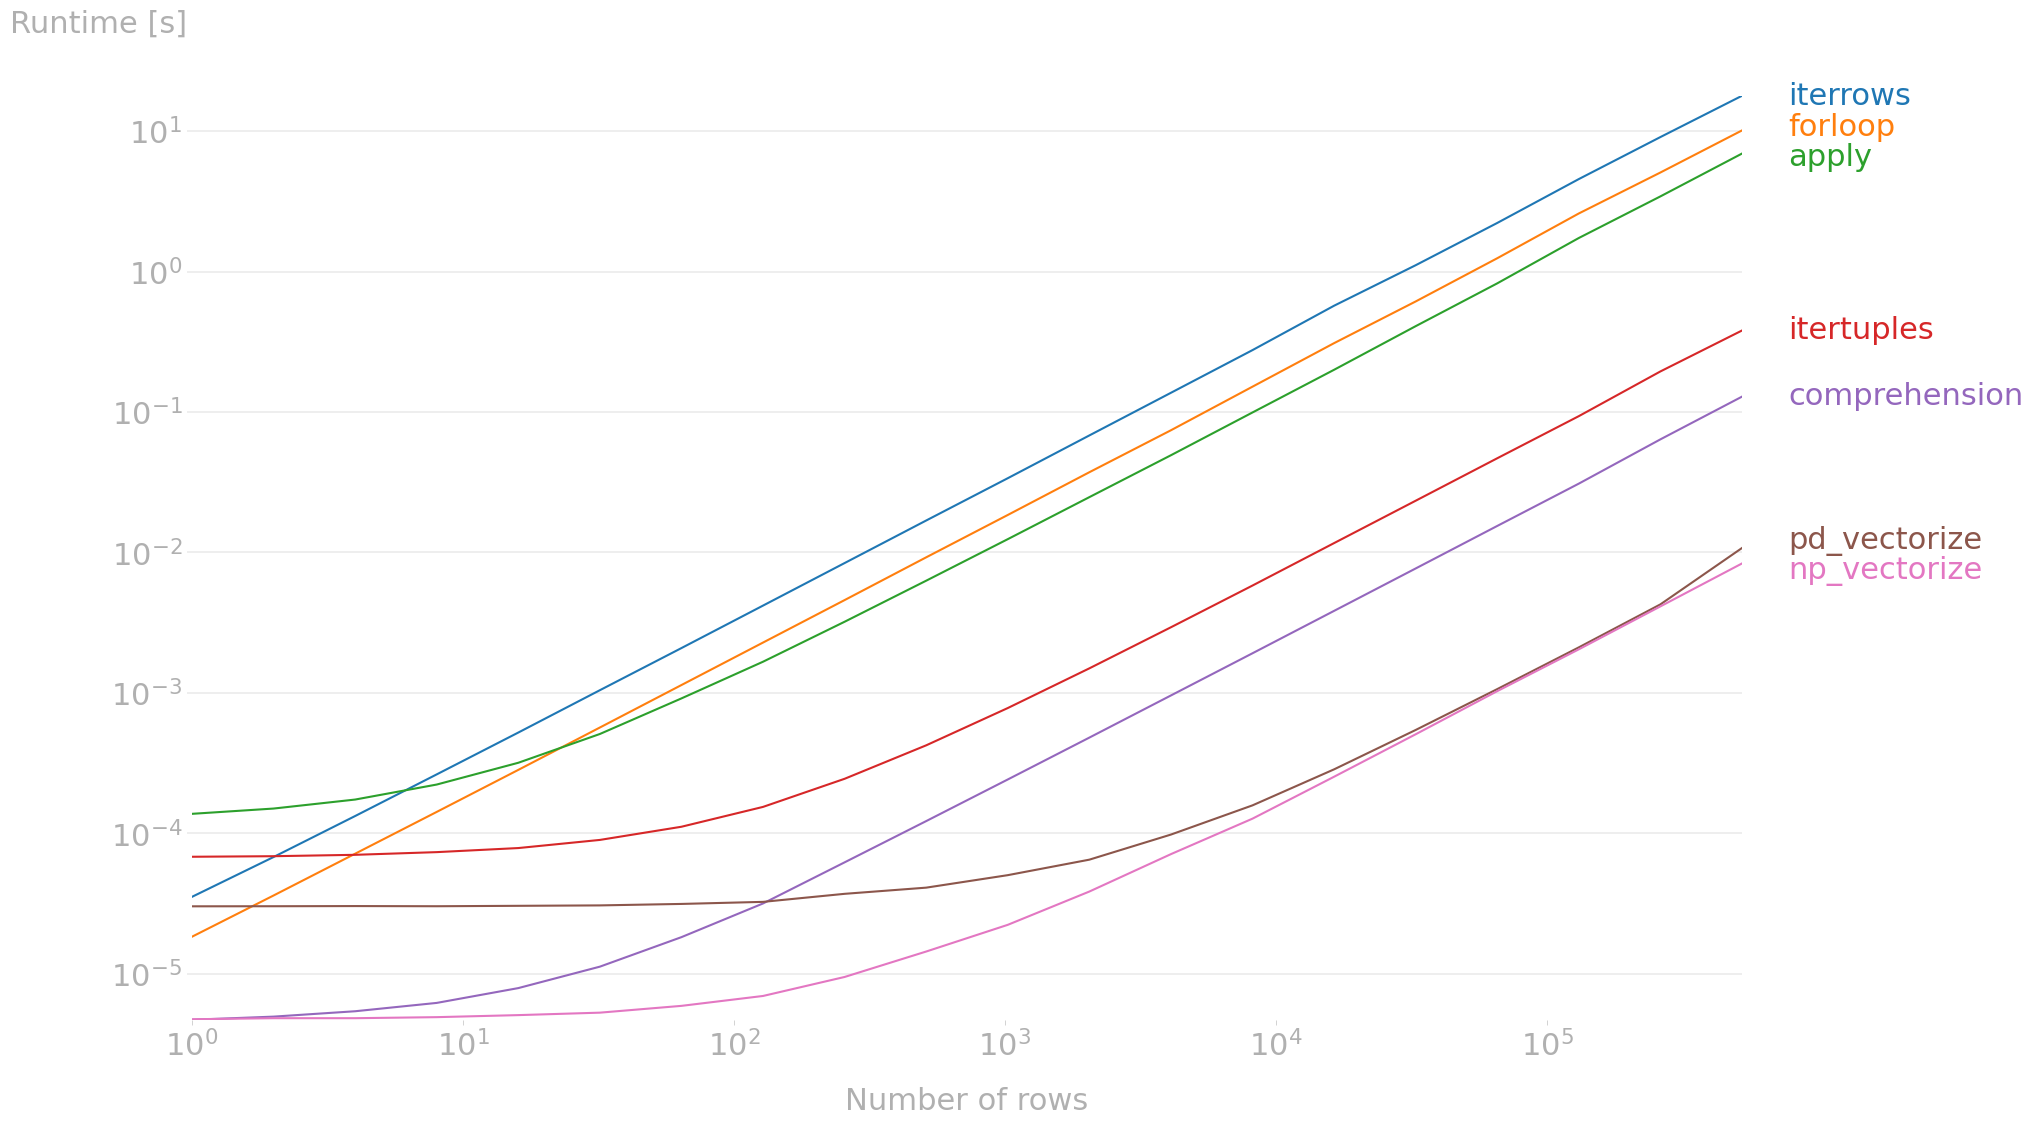

In [10]:
!pip install -q perfplot

import perfplot
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

# Techniques
def forloop(df):
    total = []
    for index in range(len(df)):
        total.append(df['col1'].iloc[index]
                   + df['col2'].iloc[index])
    return total

def itertuples(df):
    total = []
    for row in df.itertuples():
        total.append(row[1] + row[2])
    return total

def iterrows(df):
    total = []
    for index, row in df.iterrows():
        total.append(row['col1']
                   + row['col2'])
    return total

def apply(df):
    return df.apply(lambda row: row['col1']
                              + row['col2'], axis=1).to_list()

def comprehension(df):
    return [src + dst for src, dst in zip(df['col1'], df['col2'])]

def pd_vectorize(df):
    return (df['col1'] + df['col2']).to_list()

def np_vectorize(df):
    return (df['col1'].to_numpy() + df['col2'].to_numpy()).tolist()

# Perfplot
functions = [iterrows, forloop, apply, itertuples,
             comprehension, pd_vectorize, np_vectorize]
df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})

out = perfplot.bench(
      setup=lambda n: pd.concat([df]*n, ignore_index=True),
      kernels=functions,
      labels=[str(f.__name__) for f in functions],
      n_range=[2**n for n in range(20)],
      xlabel='Number of rows',
)

plt.figure(figsize=(20,12))
out.show()

Confirmamos que la más rápida es la vectorización NumPy.